In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas

In [2]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit

In [3]:
client = CryptoHistoricalDataClient()

In [4]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame(amount=15, unit=TimeFrameUnit('Min')),
    #timeframe=TimeFrame.Minute,
    start="2023-05-18",
    end="2024-05-18"
)

btc_bars = client.get_crypto_bars(request_params=request_params)

#print(btc_bars["BTC/USD"])

dates = []
stats = []
for item in btc_bars["BTC/USD"]:
    dates.append(dict(item)['timestamp'])
    
    temp_stats = []
    for key, value in dict(item).items():
        if key not in ['timestamp', 'symbol']:
            temp_stats.append(value) 
    stats.append(temp_stats)

print(len(stats))
    
data = torch.tensor(stats)
print(data.shape)


35108
torch.Size([35108, 7])


In [28]:
f = open('data/btc_minute_23-05-18_24-05-18.csv', 'a')

for item in data:
    
    string = ', '.join(str(list(item))) + '\n'

    f.write(string)

TypeError: float() argument must be a string or a real number, not 'list'

In [16]:
time_period = 60
feature_space = 7
output_size = 3 #[down, no change, up]
batch_size = 16

device = 'cuda' if torch.cuda.is_available() else 'mps'

In [17]:
class BTCDataset(Dataset):

    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        random_index = torch.randint(0, len(self.data) - time_period, size=(1,))
        return self.data[random_index:random_index+time_period+1]
    
    def __len__(self):
        return len(self.data)

In [18]:
dataset = BTCDataset(data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [142]:
for item in dataloader:
    print(item.shape)
    break

torch.Size([16, 61, 7])


In [19]:
class FeedForward(nn.Module):
    
    def __init__(self, dropout, embedding_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.ReLU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
    
class Head(nn.Module):
    
    def __init__(self, dropout, embedding_dim, head_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        #self.register_buffer('tril', torch.tril(torch.ones(time_period, time_period)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) #(B, T, head_size)
        q = self.query(x) #(B, T, head_size)
        att = q @ k.transpose(-2, -1) * (k.size(-1) ** -0.5) # Want (B, T, T) where there is a value for how each token relates to each other token
        # want k to be (B, C, T) k.transpose(-2, -1) swaps the last 2 dimensions, giving (B, C, T)
        #att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1) 
        att = self.dropout(att)
        v = self.value(x)
        out = att @ v
        return out

class MultiHeadAttention(nn.Module):
    
    def __init__(self, dropout, embedding_dim, head_size, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([Head(dropout, embedding_dim, head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class Block(nn.Module):

    def __init__(self, dropout, embedding_dim, head_size, num_heads):
        super().__init__()
        self.self_att = MultiHeadAttention(dropout, embedding_dim, head_size, num_heads)
        self.ffwd = FeedForward(dropout, embedding_dim)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x = x + self.self_att(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class Transformer(nn.Module):

    def __init__(self, dropout, embedding_dim, num_heads, head_size, num_layers):
        super().__init__()
        self.data_embedding = nn.Linear(feature_space, embedding_dim)
        self.position_embedding = nn.Embedding(time_period, embedding_dim)
        self.blocks = nn.Sequential(*[Block(dropout, embedding_dim, head_size, num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, output_size)
    
    def forward(self, x):
        #B, T = x.shape

        data_embeddings = self.data_embedding(x)
        positional_embeddings = self.position_embedding(torch.arange(time_period, device=device))
        
        x = data_embeddings + positional_embeddings
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        return logits


In [30]:
model = Transformer(dropout=0.2, embedding_dim=32, num_heads=4, head_size=8, num_layers=8).to(device)
loss_function = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)

num_epochs = 3

In [21]:
threshold = 0.0005
def get_targets(chunk):
    # returns 1 hot encoding of whether the stock goes up or down
    target = chunk[:, time_period, :]
    chunk_real = chunk[:, :time_period, :]
    
    real_targets = []
    for i in range(len(chunk_real)):
        real_price = chunk_real[i, -1, 0]
        target_price = target[i, 0]
        if target_price > real_price*(1 + threshold):
            # move up
            real_targets.append([0, 0, 1])
        elif target_price < real_price*(1 - threshold):
            # move down
            real_targets.append([1, 0, 0])
        else:
            # no change
            real_targets.append([0, 1, 0])

    return torch.tensor(real_targets, device=device, dtype=torch.float32)

def normalize_features(real_chunk):
    for j in range(time_period):
        for i in range(feature_space):
            feature_mean = sum(real_chunk[:, j, i]) / batch_size
            feature_stdev = torch.std(real_chunk[:, j, i])
            real_chunk[:, j, i] -= feature_mean
            real_chunk[:, j, i] /= feature_stdev

    return real_chunk
            

In [31]:
print(sum(p.numel() for p in model.parameters()))

losses = []
iteration = 0
for epoch in range(num_epochs):
    
    for chunk in dataloader:        
        targets = get_targets(chunk)
        chunk_real = chunk[:, :time_period, :].to(device)
        normalized_chunk = normalize_features(chunk_real)
        #print(normalized_chunk[:, 0, 0])
        logits = model(normalized_chunk)
        
        #logit_probs = F.softmax(logits[:, -1, :], dim=-1)
        #logits = F.softmax(logits[:, -1, :], dim=-1)
       # loss = loss_function(logit_probs, targets)
        loss = loss_function(logits, targets)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if iteration % 250 == 0:
            print(iteration, loss.item())
        
        iteration += 1

        

print(iteration)

        

103203
0 4.1445393562316895
250 0.9487204551696777
500 0.7508211135864258
750 0.7359187006950378
1000 0.6978713870048523
1250 0.6806390881538391
1500 0.6510839462280273
1750 0.6311411261558533
2000 0.6393172144889832
2250 0.65591961145401
2500 0.6939006447792053
2750 0.6041336059570312
3000 0.624991238117218
3250 0.6172786355018616
3500 0.6348392367362976
3750 0.593292236328125
4000 0.6152873039245605
4250 0.6227607131004333
4500 0.647491455078125
4750 0.6090921759605408
5000 0.6278034448623657
5250 0.6026400923728943
5500 0.6244016289710999
5750 0.7229809761047363
6000 0.6438679099082947
6250 0.6504530310630798
6500 0.649500846862793
6585


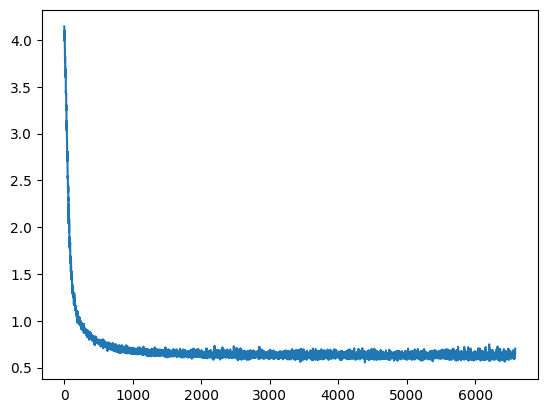

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses[:len(losses)-1])
plt.show()

In [171]:
loss_fn = nn.BCEWithLogitsLoss()

a = torch.tensor([[1,0], [0,1], [1,0], [0,1]], dtype=torch.float32)
b = torch.tensor([[1.0, -0.1], [0.2, 1.3], [0.4, .6], [-0.2, 1.3]], dtype=torch.float32)
print(F.softmax(b, dim=-1))
loss_fn(a,b)

tensor([[0.7503, 0.2497],
        [0.2497, 0.7503],
        [0.4502, 0.5498],
        [0.1824, 0.8176]])


tensor(0.5032)

In [ ]:
# next steps: normalize/scale the features,,,,???? center around 0 and 1 STDEV, should be a cool way to do this in pytorch
# rewrite the code to be more clean

#back test this on some new data
